In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
#model = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cpu")


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [6]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)

Loading predictions from ./saved_predictions/2c92d1aaa0cc2db665dc992cc2c004015b949d723cda785c3c3a140ebe8a808b.pkl
Predictions already exist, loading them...
Loading predictions from ./saved_predictions/27b7022a01eb9f119e53d0e6c2c7e9a25a4444c25cea01599ce79e2a14f06cd0.pkl
Predictions already exist, loading them...


In [7]:
# Filter the preds_cal and preds_val with confidence below 0.001


def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds


preds_cal = filter_preds(preds_cal)
preds_val = filter_preds(preds_val)

In [8]:
from cods.od.utils import (
    match_predictions_to_true_boxes,
    generalized_iou,
    assymetric_hausdorff_distance,
)
import numpy as np
from cods.od.loss import (
    ODBinaryClassificationLoss,
    ClassificationLossWrapper,
    PixelWiseRecallLoss,
)
import torch

# Measure, for several distance function, the average distance in the match
loss_cls = ClassificationLossWrapper(ODBinaryClassificationLoss())
loss_loc = PixelWiseRecallLoss()
results = {}
thresholds = np.linspace(0, 0.95, 50)
FUNCTIONS = {
    "giou": generalized_iou,
    "hausdorff": assymetric_hausdorff_distance,
    "lac": lambda x,y: 1
}
for matching_function in ["lac"]:#["hausdorff", "giou"]:
    for class_factor in [0]:#[0, 1, 5, 25]:
        key = f"{matching_function}-{class_factor}"  # {'class_factor' if class_factor else ''}"
        key_loc = f"{key}-loc"
        key_cls = f"{key}-cls"
        results[key] = []
        results[key_loc] = []
        results[key_cls] = []
        curr_func = FUNCTIONS[matching_function]
        for conf_thr in thresholds:
            match_predictions_to_true_boxes(
                preds_cal,
                distance_function=matching_function,
                overload_confidence_threshold=conf_thr,
                class_factor=class_factor,
            )
            distances = []
            dist_cls = []
            dist_loc = []
            for i in range(len(preds_cal)):
                true_boxs = preds_cal.true_boxes[i]
                true_clss = preds_cal.true_cls[i]
                pred_boxs = preds_cal.pred_boxes[i]
                pred_clss = preds_cal.pred_cls[i]
                matching = preds_cal.matching[i]
                if len(matching) == 0 or len(matching[0]) == 0:
                    continue
                try:
                    pred_boxs = list(
                        [pred_boxs[match_idx[0]] for match_idx in matching]
                    )  # if (len(preds_cal.matching[i]) > 0) or (np.array(list([len(x)>0 for x in preds_cal.matching[i]]))).sum() else []
                except:
                    print(matching)
                pred_clss = list(
                    [pred_clss[match_idx[0]] for match_idx in matching]
                )
                conf_boxs = pred_boxs
                conf_clss = list([pcls.argmax(0)[None] for pcls in pred_clss])
                loss_cls_val = loss_cls(
                    true_boxs, true_clss, conf_boxs, conf_clss
                )
                loss_loc_val = loss_loc(
                    true_boxs, true_clss, conf_boxs, conf_clss
                )
                dist_cls.append(loss_cls_val)
                dist_loc.append(loss_loc_val)

                for j in range(len(true_boxs)):
                    if len(preds_cal.matching[i][j]) == 0:
                        continue
                    match_idx = preds_cal.matching[i][j][0]
                    # try:
                    #     match_idx = preds_cal.matching[i][j][0]
                    # except:
                    #     print(preds_cal.matching[i])
                    dist = curr_func(
                        preds_cal.true_boxes[i][j],
                        preds_cal.pred_boxes[i][match_idx],
                    )

                    # Compute classification and localization loss

                    distances.append(dist)
            results[key].append(np.mean(distances))
            results[key_cls].append(np.mean(dist_cls))
            results[key_loc].append(np.mean(dist_loc))

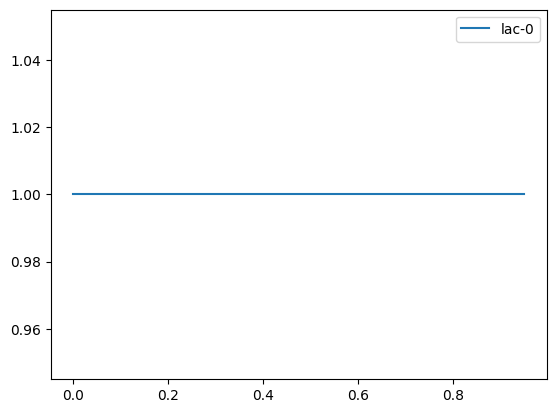

In [9]:
import matplotlib.pyplot as plt

for k, v in results.items():
    if "giou" in k:
        v = 1 - np.array(v)
    if len(k.split("-")) == 2:
        v = np.array(v)
        v /= v.max()
        plt.plot(thresholds, v, label=k)
plt.legend()

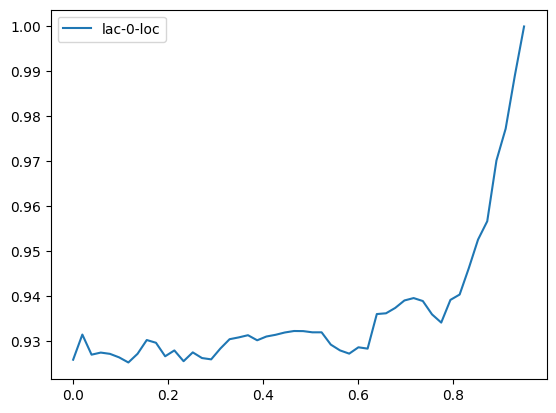

In [10]:
import matplotlib.pyplot as plt

for k, v in results.items():
    if "loc" in k:
        v = np.array(v)
        v /= v.max()
        plt.plot(thresholds, v, label=k)
plt.legend()

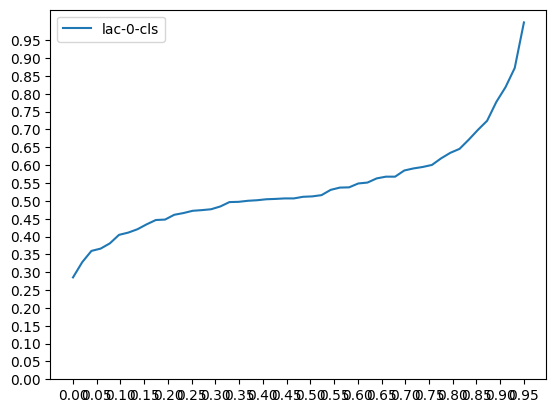

In [11]:
import matplotlib.pyplot as plt

for k, v in results.items():
    if "cls" in k:
        v = np.array(v)
        v /= v.max()
        plt.plot(thresholds, v, label=k)
# put more ticks 
plt.xticks(np.arange(0, 1, 0.05))
plt.yticks(np.arange(0,1,0.05))
plt.legend()

In [14]:
(np.diff(results["lac-0-cls"])>0).all()

True